## Assignment 1
##### CID: 01731821

##### Google Colab notebook link: [Google Colab Notebook](https://colab.research.google.com/drive/12NiqrLvKs310zcdSNU6793pUpuo3LamV?usp=sharing)

Before starting any of the questions, we need to import the required libraries.

In [109]:
# Import necessary libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

We also load and import the necessary datasets for our analysis. Please note that we choose to not standardise or normalize our dataset as it is not necessary for our analysis. In fact, the MNIST dataset contains images of handwritten digits, which are already on the same scale and have the same size.

In [110]:
# Import MNIST dataset
train_set = torchvision.datasets.MNIST(root='./', train=True, download=True, transform=transforms.ToTensor())
test_set = torchvision.datasets.MNIST(root='./', train=False, download=True, transform=transforms.ToTensor())

We also set the random seed to my CID number to be able to reproduce our results.

In [3]:
# Set seed for reproducibility
SEED = 1731821
np.random.seed(SEED)
torch.manual_seed(SEED)
print("Seed set to", SEED)

## PART I: Implementations

This first part consists of implementing the essential functions in order to perform our analysis. We will start by defining the functions in order to build, train and test our neural network. We will build a very maleable ``main()`` function able to perform any kind of analysis we want with different parameters and different datasets.

#### Task 1: Implement a fully-connected neural network

In [4]:
class Net(nn.Module):
    """
    A fully-connected neural network with ReLU activation and softmax output.
    
    Args:
        dim (int): The dimension of the input.
        nclass (int): The number of classes.
        width (int): The width of the hidden layers.
        depth (int): The number of hidden layers.
    """
    def __init__(self, dim, nclass, width, depth):
        # Call the parent constructor
        super().__init__()
        # Define the parameters
        self.dim = dim
        self.nclass = nclass
        self.width = width
        self.depth = depth
        # Define the layers
        self.layers = nn.ModuleList([nn.Flatten()])
        self.layers.extend([nn.Linear(self.dim, self.width)])
        self.layers.extend([nn.ReLU()]) # Add ReLU activation function as every Linear layer is followed by a ReLU activation function
        # Define the hidden layers
        for i in range(self.depth-1):
            self.layers.extend([nn.Linear(self.width, self.width), nn.ReLU()])
        # Define the output layer
        self.layers.extend([nn.Linear(self.width, self.nclass)])

    
    def forward(self, input):
        # Forward pass
        x = input
        for layer in self.layers:
            x = layer(x)
        return x

This new class ``Net`` allows us to build a neural network with given dimensions, number of classes, width and depth. We have also added a ``forward()`` method function which allows us to perform a forward pass on the network. 
> In the building of our neural network, we have used ***depth-1*** in our for loop for the hidden layers, as there is already one Linear layer with a ReLu activation that takes the input and transforms it into the first hidden layer. In fact, as indicated in an [EdStem post](https://edstem.org/us/courses/32063/discussion/2652620 "Number of hidden layers forum question") by the lecturer, the number of hidden layers is the number of layers with an activation function.

#### Task 2: Implement the data loading function

In [5]:
def loading_data(batch_size, train_set, test_set):
    """
    This function loads the data using the torch.utils.data.DataLoader function.
    
    Args:
        batch_size (int): The batch size.
        train_set (torch.utils.data.Dataset): The training set.
        test_set (torch.utils.data.Dataset): The test set.
        
    Returns:
        trainloader (torch.utils.data.DataLoader): The training set loader.
        testloader (torch.utils.data.DataLoader): The test set loader.
    """
    # Load the data
    trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    testloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

    return trainloader, testloader

The function ``loading_data()`` allows us to load the MNIST dataset as a training set and a test set.

#### Task 3: Implement a function that does one training epoch

In [6]:
def train_epoch(trainloader, net, optimizer, criterion):
    """
    Trains the network for one epoch.
    
    Args:
        trainloader: The training data loader.
        net: The network to train.
        optimizer: The optimizer to use.
        criterion: The loss function to use.
        
    Returns:
        The average train loss over the epoch.
        The train error over the epoch.
    """
    # Set the network to training mode
    net.train()
    # Initialize the loss and error
    total_loss = 0
    total_error = 0
    # Loop over the training set
    for i, (images, labels) in enumerate(trainloader):
        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # Update the loss and error
        total_loss += loss.item()
        total_error += (outputs.argmax(dim=1) != labels).sum().item()

    
    return total_loss / len(trainloader), total_error / len(trainloader.dataset) # Return the average train loss and train error

The function ``train_epoch()`` allows us to train our neural network for one epoch. It takes as input the neural network, the training set, the optimizer and the criterion function. It returns the average loss and the average error of the training set.
> Even though it was not initially asked in the task guidance, we also return the average error of the training set in order to be able to plot them later on in our analysis and compute the generalization error for example.

#### Task 4: Implement a function that does one test epoch

In [7]:
def test_epoch(testloader, net, criterion):
    """
    Tests the network for one epoch.

    Args:
        testloader: The test data loader.
        net: The network to test.
        criterion: The loss function to use.
    
    Returns:
        The average test loss over the epoch.
        The test error over the epoch.
    """
    # Set the network to evaluation mode
    net.eval()
    # Initialize the loss and error
    test_loss = 0
    correct = 0
    total = 0
    # Loop over the test set
    with torch.no_grad():
        for i, (images, labels) in enumerate(testloader):
            outputs = net(images)
            loss = criterion(outputs, labels)
            # Update the loss and error
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return test_loss / len(testloader), 1 - correct / total # Return the average test loss and test error

Similarly, the function ``test_epoch()`` allows us to test our neural network for one epoch. It takes as input the neural network, the test set and the criterion function. It returns the average loss and the average error of the test set.

#### Task 5: Write a piece of code that sets the hyperparameters and that allows to run the train and test epochs

In [8]:
def main(batch_size, dim, nclass, width, depth, lr, epochs, train_set, test_set, Adam=True, momentum=None, early_stop_loss=None ,verbose=True):
    """
    This function runs the training and testing epochs.
    
    Args:
        batch_size (int): The batch size.
        dim (int): The dimension of the input.
        nclass (int): The number of classes.
        width (int): The width of the hidden layers.
        depth (int): The number of hidden layers.
        lr (float): The learning rate.
        epochs (int): The number of epochs.
        train_set (torch.utils.data.Dataset): The training set.
        test_set (torch.utils.data.Dataset): The test set.
        Adam (bool): Whether to use Adam or SGD.
        momentum (float): The momentum to use for SGD.
        early_stop_loss (float): The loss threshold to stop the training.
        verbose (bool): Whether to print the results.
    
    Returns:
        The train loss over the epochs.
        The test loss over the epochs.
        The train error over the epochs.
        The test error over the epochs.
    """

    # load data
    trainloader, testloader = loading_data(batch_size, train_set, test_set)

    # define network
    net = Net(dim, nclass, width, depth)

    # define criterion function
    criterion = nn.CrossEntropyLoss()

    # define Adam or SGD optimizer
    if Adam:
        optimizer = optim.Adam(net.parameters(), lr=lr)
    else:
        if momentum is None:
            optimizer = optim.SGD(net.parameters(), lr=lr)
        else:
            optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)

    # Storing the results for each epoch
    store_train_loss = []
    store_test_loss = []
    store_train_error = []
    store_test_error = []
    for epoch in range(1, epochs+1):
        # Training and testing the network
        train_loss, train_error = train_epoch(trainloader, net, optimizer, criterion)
        test_loss, test_error = test_epoch(testloader, net, criterion)
        # Storing the results
        store_train_loss.append(train_loss)
        store_test_loss.append(test_loss)
        store_train_error.append(train_error)
        store_test_error.append(test_error)
        # Printing the results
        if verbose:
            print(f"Epoch: {epoch:03} | Train Loss: {train_loss:.04} | Test Loss: {test_loss:.04} | Train Error: {train_error:.04} | Test Error: {test_error:.04}")
        # Early stopping if the loss is below a certain threshold (i.e. convergence is attained)
        if early_stop_loss:
            if train_loss < early_stop_loss:
                print(f"Early stopping at epoch {epoch} with train loss {train_loss}")
                break
    return store_train_loss, store_test_loss, store_train_error, store_test_error

This function ``main()`` allows us to perform our analysis by putting together all the functions we have implemented. It takes as input all the parameters needed for our analysis in Part II. It returns the average loss and the average error of the training and test sets. This function is very maleable and allows us to perform any kind of analysis we want with different parameters and different datasets.
> Note that we store the whole history of the losses and errors of the training and test sets at each epoch in order to be able to investigate their behaviours later on in our analysis.

> Note also that we have implemented an early stopping parameter, which allows us to stop the training of our neural network if the loss of the train set has converged before the maximum number of epochs. Even though this parameter will not be used for all the analysis in Part II, we have decided to implement it in order to be able to use it later on if needed. It could be very useful for example if we want to compare the performances of different neural networks with different hyperparameters.

## PART II: Numerical exploration

In this second part of the assignment, we will perform an exploration of the hyperparameters of our neural network. We will investigate the impact of the number of hidden layers, the learning rate, the batch size and the number of neurons per hidden layer on the performance of our neural network. We will analyse the impact of these hyperparameters on the MNIST dataset that we have previously loaded.

#### Task 6: Analyse the performance for wide vs. deep neural networks

First of all, we want to analyse the performance of neural networks with different depths. We will investigate the impact of the number of hidden layers on the performance of our neural network. We will use a fixed width of 256 neurons per hidden layer and a fixed learning rate of 0.001 for the Adam optimizer. We will also use a batch size of 32 and train our neural network for 20 epochs. We have chosen these specific hyperparameters because after multiple other trials, we have found that they gave the best results in terms of the results we are expecting and the training time.
> Please note that we have chosen to use the Adam optimizer but similar results could have been obtained with the SGD optimizer.

In [94]:
# Define the hyperparameters
depths = [1, 5, 10] # Varying hyperparameter
width = 256 # Fixed hyperparameter according to exercise guidelines
lr = 0.001
epochs = 20
batch_size = 32
dim = 784
nclass = 10
Adam = True

# Store the results
store_depth = {}

# Run the main function for different depths 
for depth in depths:
    print(f"Depth: {depth}")
    train_loss, test_loss, train_error, test_error = main(batch_size, dim, nclass, width, depth, lr, epochs, train_set, test_set, Adam=Adam)
    store_depth[depth] = [train_loss, test_loss, train_error, test_error]

Depth: 1
Epoch: 001 | Train Loss: 0.2563 | Test Loss: 0.1279 | Train Error: 0.07307 | Test Error: 0.0385
Epoch: 002 | Train Loss: 0.1041 | Test Loss: 0.08615 | Train Error: 0.03107 | Test Error: 0.026
Epoch: 003 | Train Loss: 0.06867 | Test Loss: 0.09303 | Train Error: 0.02108 | Test Error: 0.0287
Epoch: 004 | Train Loss: 0.04938 | Test Loss: 0.07906 | Train Error: 0.01572 | Test Error: 0.0254
Epoch: 005 | Train Loss: 0.03632 | Test Loss: 0.06643 | Train Error: 0.0115 | Test Error: 0.021
Epoch: 006 | Train Loss: 0.0278 | Test Loss: 0.08703 | Train Error: 0.00835 | Test Error: 0.0245
Epoch: 007 | Train Loss: 0.0216 | Test Loss: 0.07938 | Train Error: 0.00685 | Test Error: 0.0211
Epoch: 008 | Train Loss: 0.01659 | Test Loss: 0.07248 | Train Error: 0.00525 | Test Error: 0.0189
Epoch: 009 | Train Loss: 0.01578 | Test Loss: 0.07456 | Train Error: 0.004933 | Test Error: 0.0195
Epoch: 010 | Train Loss: 0.01167 | Test Loss: 0.08876 | Train Error: 0.003733 | Test Error: 0.0212
Epoch: 011 | Trai

In [116]:
# Construct pandas table of different train loss and test loss for different depths
df = pd.DataFrame(columns=["Depth", "Train loss", "Test loss"])
for depth in depths:
    df = pd.concat([df, pd.DataFrame([[depth, store_depth[depth][0][-1], store_depth[depth][1][-1]]], columns=["Depth", "Train loss", "Test loss"])])
df.reset_index(drop=True, inplace=True)
df

,Depth,Train loss,Test loss
0,1,0.005095,0.100714
1,5,0.019696,0.107610
2,10,0.038200,0.115827


Table of results in Markdown format for Task 6:

| Depth | Train loss | Test loss |
| --- | --- | --- |
| 1 | 0.005095 | 0.100714 |
| 5 | 0.019696 | 0.107610 |
| 10 | 0.038200 | 0.115827 |

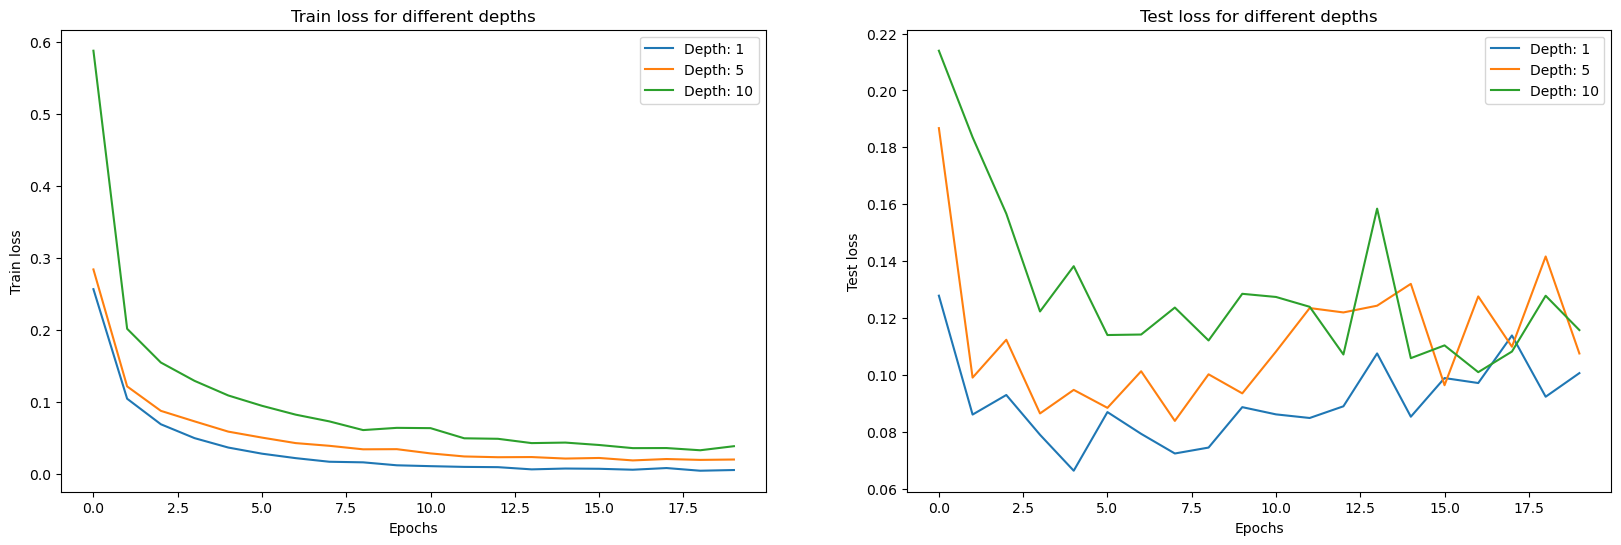

In [96]:
# Plot the train loss for different depths and test loss for different depths as subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
for depth in depths:
    ax[0].plot(store_depth[depth][0], label=f"Depth: {depth}")
    ax[1].plot(store_depth[depth][1], label=f"Depth: {depth}")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Train loss")
ax[0].legend()
ax[0].title.set_text("Train loss for different depths")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Test loss")
ax[1].legend()
ax[1].title.set_text("Test loss for different depths")
plt.show()

> Left plot: We can see that the train loss are all decreasing meaning that all our models are converging. However, some neural networks seem to converge faster than others: Depth 1 converges faster than Depth 10.

> Right plot: Similarly, the test loss for the three neural networks decrease as the number of epochs increases. However, the test loss for the neural network with depth 1 is lower than the test loss for the neural networks with depth 5 and 10. This means that the neural network with depth 1 is the best performing model. It is possible that the neural network with depth 10 is overparametrized and thus overfits the training set. This would explain why the test loss is higher than the test loss for the neural network with depth 1. But this does not seem to be the case here, as the train loss for the neural network with depth 10 is higher than the train loss for the neural network with depth 1. It seems that the neural network with depth 10 mainly struggles to converge optimally as the loss landscape is more ragged.

After finding the right set of parameters that allow us to make our neural networks converge for the different depths, we obtain very interesting results. Indeed, we notice from our plots that the deeper the neural network the harder it seems to train it: the train loss seems to converge much more slowly for deeper neural networks. It seems that it requires more epochs for deeper neural network to be able to obtain a neural network that converges. This makes sense because as we have seen in lectures, the deeper the model, the more ragged the loss landscape is. In other words, the more complex it is to optimise it. This is because deep neural networks are more likely to get stuck in local optima and can suffer from vanishing or exploding gradients, which can make training slow or unstable. Non-deep neural networks, on the other hand, may be easier to train because they have fewer layers and parameters.

Moreover, we can notice from our test loss plot that the test loss is also higher for deeper neural networks. This is due to the fact that the deeper the neural network is, the more it is able to overfit the training set. Indeed, the deeper the neural network is, the more parameters it has and the more it is able to fit the training set. However, it is also more likely to overfit the training set and to perform poorly on the test set. This is because deep neural networks have a large number of parameters, which gives them a greater capacity to memorize noise in the data. Non-deep neural networks, on the other hand, have fewer parameters and may be less prone to overfitting. However, this difference in the test losses in our case could be due to the fact that the deep neural network mainly struggles to converge optimally as the loss landscape is more ragged. Therefore, it is possible that if we had trained the deep neural network for more epochs, the test loss would have been lower than the test loss for the neural network with depth 1.

#### Task 7: Compare SGD with small and large learning rates

Secondly, we want to analyse the performance of neural networks with different learning rates using SGD optimizer. We will investigate the impact of the learning rate on the performance of our neural network. We will use a fixed width of 256 neurons per hidden layer and a fixed depth of 1 hidden layer. We will also use a batch size of 32 and train our neural network for 50 epochs. We have set the parameters in this way because after multiple other trials, we have found that they gave the best results in terms of the results we are expecting and the training time.

In [10]:
# Define the hyperparameters
learning_rates = [0.001, 0.01, 0.1] # Varying hyperparameter
depth = 1 # Fixed hyperparameter according to exercise guidelines
width = 256 # Fixed hyperparameter according to exercise guidelines
epochs = 50
batch_size = 32
dim = 784
nclass = 10
Adam = False # Fixed hyperparameter according to exercise guidelines

# Store the results
store_lr = {}

# Run the main function for different learning rates
for lr in learning_rates:
    print(f"Learning rate: {lr}")
    train_loss, test_loss, train_error, test_error = main(batch_size, dim, nclass, width, depth, lr, epochs, train_set, test_set, Adam=Adam, momentum=0.9, early_stop_loss=0.05)
    store_lr[lr] = [train_loss, test_loss, train_error, test_error]

Learning rate: 0.001
Epoch: 001 | Train Loss: 0.8742 | Test Loss: 0.4021 | Train Error: 0.1954 | Test Error: 0.1066
Epoch: 002 | Train Loss: 0.3728 | Test Loss: 0.3206 | Train Error: 0.1032 | Test Error: 0.0889
Epoch: 003 | Train Loss: 0.3184 | Test Loss: 0.2856 | Train Error: 0.08982 | Test Error: 0.0801
Epoch: 004 | Train Loss: 0.2874 | Test Loss: 0.2641 | Train Error: 0.08165 | Test Error: 0.0737
Epoch: 005 | Train Loss: 0.2634 | Test Loss: 0.2449 | Train Error: 0.07428 | Test Error: 0.0683
Epoch: 006 | Train Loss: 0.2431 | Test Loss: 0.2277 | Train Error: 0.06898 | Test Error: 0.0639
Epoch: 007 | Train Loss: 0.2256 | Test Loss: 0.2131 | Train Error: 0.06332 | Test Error: 0.06
Epoch: 008 | Train Loss: 0.2101 | Test Loss: 0.2 | Train Error: 0.05897 | Test Error: 0.0561
Epoch: 009 | Train Loss: 0.1968 | Test Loss: 0.189 | Train Error: 0.05527 | Test Error: 0.0544
Epoch: 010 | Train Loss: 0.1847 | Test Loss: 0.1766 | Train Error: 0.05192 | Test Error: 0.0514
Epoch: 011 | Train Loss: 0.

In [98]:
# Construct pandas table of different train loss and test loss for different learning rates
df = pd.DataFrame(columns=["Learning rate", "Train loss", "Test loss"])
for lr in learning_rates:
    df = pd.concat([df, pd.DataFrame([[lr, store_lr[lr][0][-1], store_lr[lr][1][-1]]], columns=["Learning rate", "Train loss", "Test loss"])])
df.reset_index(drop=True, inplace=True)
df

,Learning rate,Train loss,Test loss
0,0.001,0.049037,0.074477
1,0.010,0.046287,0.071018
2,0.100,0.047134,0.200552


Table of results in Markdown format for Task 7:
| Learning rate | Train loss | Test loss |
| --- | --- | --- |
| 0.001 | 0.049037 | 0.074477 |
| 0.01 | 0.046287 | 0.071018 |
| 0.1 | 0.047134 | 0.200552 |

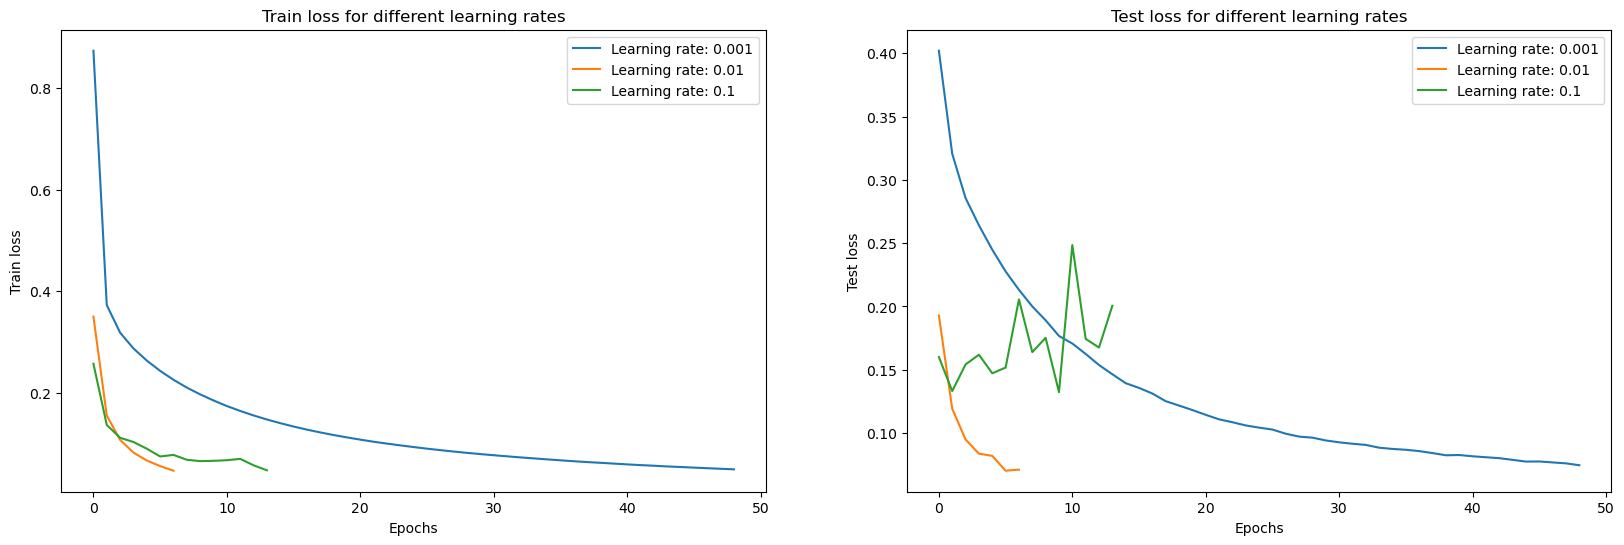

In [99]:
# Plot the train loss for different learning rates and test loss for different learning rates as subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
for lr in learning_rates:
    ax[0].plot(store_lr[lr][0], label=f"Learning rate: {lr}")
    ax[1].plot(store_lr[lr][1], label=f"Learning rate: {lr}")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Train loss")
ax[0].legend()
ax[0].title.set_text("Train loss for different learning rates")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Test loss")
ax[1].legend()
ax[1].title.set_text("Test loss for different learning rates")
plt.show()

> Left plot: For our smaller learning rate, our model seems to decrease very slowly and eventually it is not able to converge. This is due to the fact that the learning rate is too small and the model is not able to learn from the training set. On the other hand, for the biggest learning rate, the model is able to converge after ~15 epochs but we can notice that it is less smooth and that there seems to be some erratic behaviour. This is due to the fact that the learning rate is too big and the model is not able to optimally learn from the training set.

> Right plot: Similarly on this plot, we can see more evidently that for the biggest learning rate, the behaviour of the test loss is very erratic and that it is not able to perform well, compared to the other two learning rates. The learning rate of 0.01 seems to be the best performing one as it converges quickly and quite smoothly.

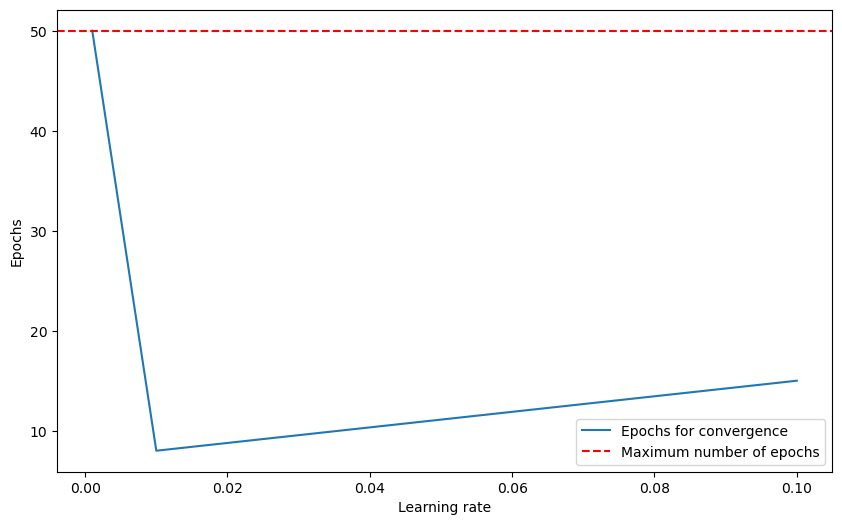

In [103]:
# Plot the number of epochs needed for convergence for each learning rate
plt.figure(figsize=(10, 6))
epochs_for_convergence = [len(store_lr[lr][0])+1 for lr in learning_rates]
plt.plot(learning_rates, epochs_for_convergence, label="Epochs for convergence")
# add horizontal line for maximum number of epochs
plt.axhline(y=50, color="r", linestyle="--", label="Maximum number of epochs")
plt.xlabel("Learning rate")
plt.ylabel("Epochs")
plt.legend()
plt.show()

> By plotting the number of epochs necessary for each method to converge in terms of the train loss, we notice that the learning rate of 0.01 is the fastest to converge. This is due to the fact that the learning rate of 0.01 is the best performing one and that it is able to learn from the training set optimally. On the other hand, the learning rate of 0.001 is the slowest to converge. This is due to the fact that the learning rate is too small and the model is not able to learn from the training set as it takes too small steps towards the minimum of the loss function.

After training our models and plotting our results we observe that the learning rate has an important impact on the performance of our neural network. Indeed, as we have seen in lectures, we notice that if the learning rate is too small, the algorithm may take too long to converge, and if the learning rate is too large, it may overshoot the minimum and fail to converge. This is exactly the behaviour the we see in our case. For small learning rate, our model takes very long to converge and for large learning rate, our model is not able to converge optimally and fluctuates. It seems like the best performing learning rate is the one that is in the middle, which is 0.01.

More precisely, we have learned that a smaller learning rate means that the algorithm takes smaller steps towards the minimum, which results in slower convergence but with fewer chances of overshooting the minimum. By looking at the plots, we indeed notice that the loss curve is very smooth and we can observe that the model converges slowly by taking small steps towards the optimum.

On the other hand, using a large learning rate can speed up the learning process, but it comes with the risk of overshooting the minimum and failing to converge. This can cause instability and oscillations in the optimization process, leading to a suboptimal solution. By looking at the plots, we indeed notice that the loss curve is very erratic and we can observe that the model is not able to converge optimally and that it is not able to learn from the training set optimally.

Finally, for the best performing learning rate, we notice that the loss curve is smooth and that the model is able to converge optimally very quickly (only a few epochs needed). This is due to the fact that the learning rate is in the middle and that the model is able to learn from the training set optimally.

#### Task 8: Compare the performance for small and large batch sizes

We now want to analyse the performance of neural networks with different batch sizes. We will investigate the impact of the batch size on the performance of our neural network. We will use a fixed width of 64 neurons per hidden layer and a fixed depth of 1 hidden layer. We will also use a increasing learning rate for the SGD optimizer with momentum and train our neural network for 100 epochs. In this task, we use an increasing learning rate in order to speed up the convergence of our neural network and be able to compare them. This task could be particularly long to train as we have to train our neural network for 100 epochs for each batch size. Moreover, we use these parameters because after **multiple** other trials (with or without increasing learning rate), we were able to observe the expected results.

> We have been indicated on an [EdStem forum page](https://edstem.org/us/courses/32063/discussion/2644086) that it is indeed possible to use increasing learning rates for this task and that in fact, it would help for our analysis.

In [113]:
# Define the hyperparameters
batch_sizes = [8, 16, 32, 64, 128, 256, 512] # Varying hyperparameter
depth = 1 # Fixed hyperparameter according to exercise guidelines
width = 64 # Fixed hyperparameter according to exercise guidelines
lr_base = 0.01 # First learning rate is set to 0.01
epochs = 100
dim = 784
nclass = 10

# Store the results
store_batch = {}

# Run the main function for different batch sizes
for batch_size in batch_sizes:
    lr = lr_base*(batch_size/8) # Learning rate is scaled with batch size
    print(f"Batch size: {batch_size}")
    train_loss, test_loss, train_error, test_error = main(batch_size, dim, nclass, width, depth, lr, epochs, train_set, test_set, Adam=False, momentum=0.9)
    store_batch[batch_size] = [train_loss, test_loss, train_error, test_error]

Batch size: 8
Epoch: 001 | Train Loss: 0.2435 | Test Loss: 0.1757 | Train Error: 0.07382 | Test Error: 0.0578
Epoch: 002 | Train Loss: 0.1168 | Test Loss: 0.1386 | Train Error: 0.0352 | Test Error: 0.0405
Epoch: 003 | Train Loss: 0.08956 | Test Loss: 0.1015 | Train Error: 0.02772 | Test Error: 0.0315
Epoch: 004 | Train Loss: 0.0744 | Test Loss: 0.0973 | Train Error: 0.02285 | Test Error: 0.0271
Epoch: 005 | Train Loss: 0.06565 | Test Loss: 0.09878 | Train Error: 0.02025 | Test Error: 0.0285
Epoch: 006 | Train Loss: 0.0539 | Test Loss: 0.09444 | Train Error: 0.01702 | Test Error: 0.027
Epoch: 007 | Train Loss: 0.04966 | Test Loss: 0.1062 | Train Error: 0.01588 | Test Error: 0.0302
Epoch: 008 | Train Loss: 0.04314 | Test Loss: 0.1333 | Train Error: 0.014 | Test Error: 0.0327
Epoch: 009 | Train Loss: 0.03697 | Test Loss: 0.137 | Train Error: 0.01145 | Test Error: 0.0334
Epoch: 010 | Train Loss: 0.03645 | Test Loss: 0.09936 | Train Error: 0.01192 | Test Error: 0.0253
Epoch: 011 | Train Los

In [125]:
# Construct pandas table of different train loss and test loss for different batch sizes
df = pd.DataFrame(columns=["Batch size", "Train loss", "Test loss"])
for batch_size in batch_sizes:
    df = pd.concat([df, pd.DataFrame([[batch_size, store_batch[batch_size][0][-1], store_batch[batch_size][1][-1]]], columns=["Batch size", "Train loss", "Test loss"])])
df.reset_index(drop=True, inplace=True)
df

,Batch size,Train loss,Test loss
0,8,0.000067,0.140315
1,16,0.000048,0.157254
2,32,0.000053,0.156481
3,64,0.000054,0.158400
4,128,0.000061,0.158896
5,256,0.000089,0.198647
6,512,0.000277,0.339887


Table of results in Markdown format for Task 8:

| Batch size | Train loss | Test loss |
| --- | --- | --- |
| 8 | 0.000067 | 0.140315 |
| 16 | 0.000048 | 0.157254 |
| 32 | 0.000053 | 0.156481 |
| 64 | 0.000054 | 0.158400 |
| 128 | 0.000061 | 0.158896 |
| 256 | 0.000089 | 0.198647 |
| 512 | 0.000277 | 0.339887 |

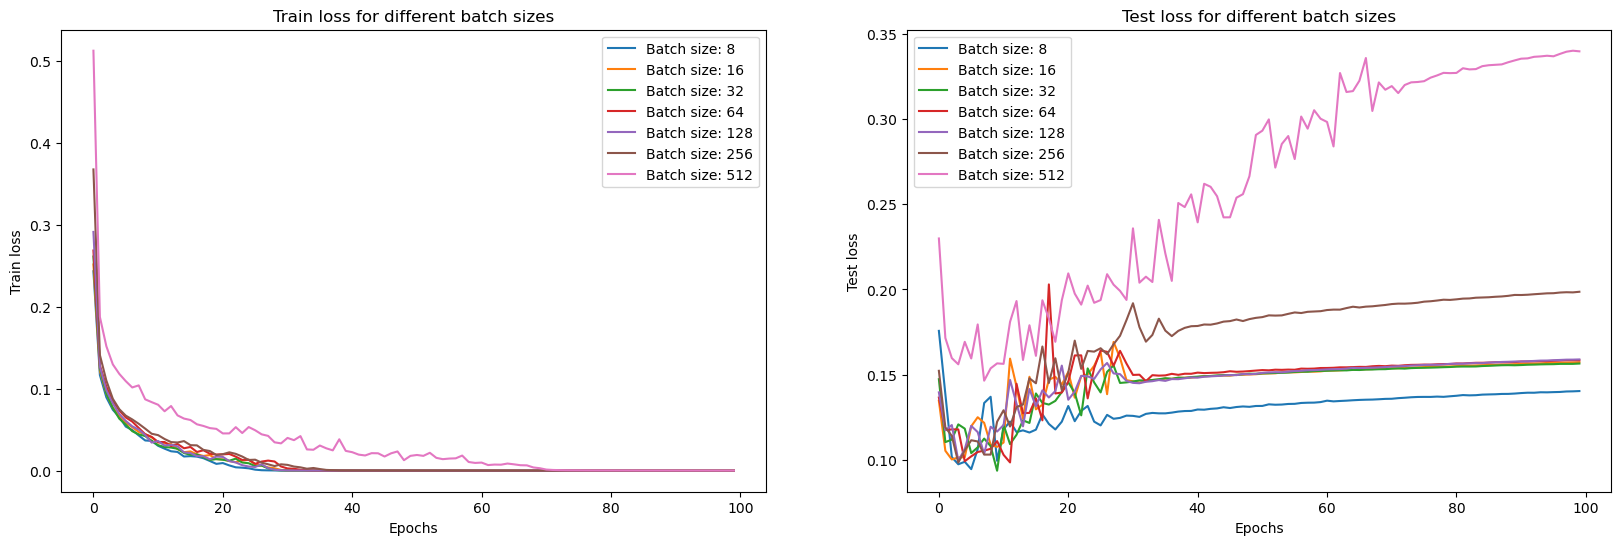

In [120]:
# Plot the train loss for different batch sizes and test loss for different batch sizes as subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
for batch_size in batch_sizes:
    ax[0].plot(store_batch[batch_size][0], label=f"Batch size: {batch_size}")
    ax[1].plot(store_batch[batch_size][1], label=f"Batch size: {batch_size}")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Train loss")
ax[0].legend()
ax[0].title.set_text("Train loss for different batch sizes")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Test loss")
ax[1].legend()
ax[1].title.set_text("Test loss for different batch sizes")
plt.show()

> Left plot: We observe on this plot that because we have used an increasing learning rate for increasing batch sizes, the neural networks are all able to converge in less than a 100 epochs and with a similar behaviour and pace. This is an important result that is essential for our analysis. The aim of is to reach a minimum for the training data that has a similar performance, but a different performance for the test data. As discussed during the lecture, our goal is to identify minima with comparable training loss values and then examine whether they exhibit similar performance on the test data.

> Right plot: We observe on this plot that the neural networks with smaller batch sizes are able to perform better than the neural networks with larger batch sizes. The test loss is indeed smaller for smaller batch sizes.


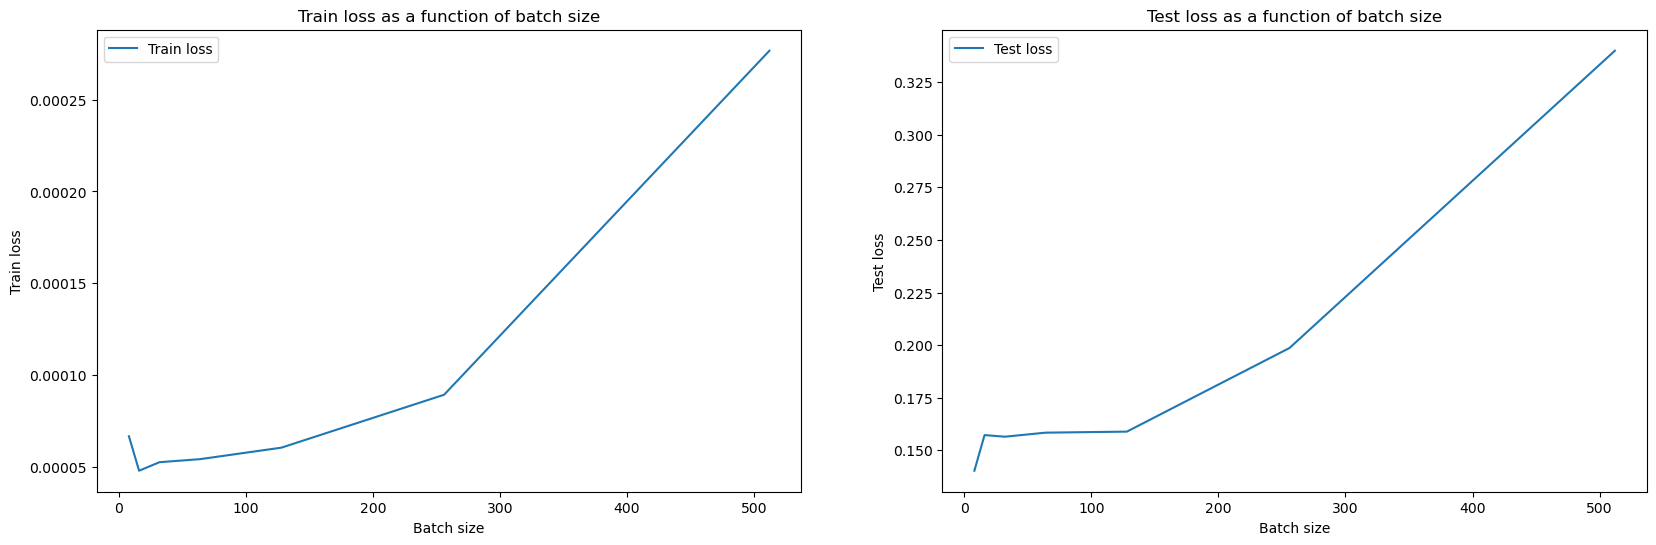

In [133]:
# Plot the train loss as a function of batch sizes and test loss as a function of batch sizes as subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax[0].plot(batch_sizes, [store_batch[batch_size][0][-1] for batch_size in batch_sizes], label="Train loss")
ax[1].plot(batch_sizes, [store_batch[batch_size][1][-1] for batch_size in batch_sizes], label="Test loss")
ax[0].set_xlabel("Batch size")
ax[0].set_ylabel("Train loss")
ax[0].legend()
ax[0].title.set_text("Train loss as a function of batch size")
ax[1].set_xlabel("Batch size")
ax[1].set_ylabel("Test loss")
ax[1].legend()
ax[1].title.set_text("Test loss as a function of batch size")
plt.show()

> Left plot: We can observe that the train loss is increasing as the batch size increases. This is due to the fact that the batch size is the number of samples that are used to compute the gradient. Therefore, the larger the batch size, the more samples are used to compute the gradient and the more the gradient is smoothed. This is why the train loss is increasing as the batch size increases.

> Right plot: Similarly, we can observe that the test loss is increasing as the batch size increases.


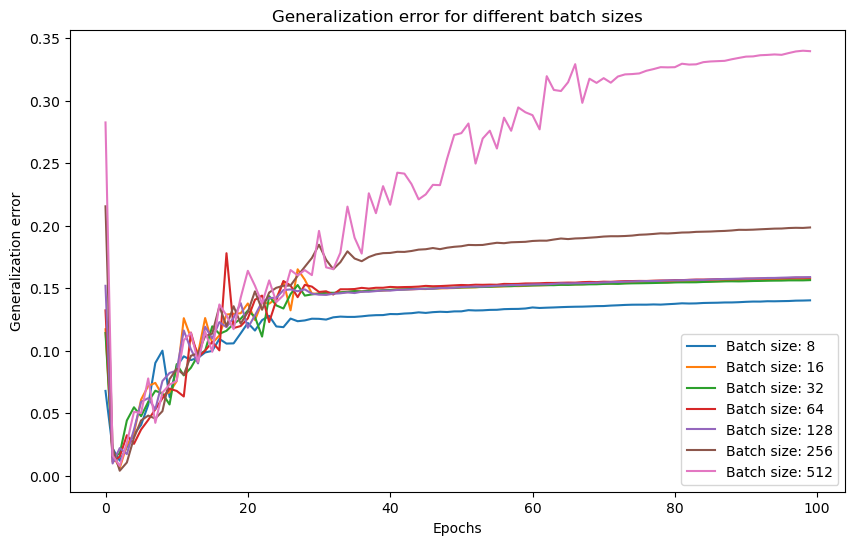

In [124]:
# Plot the generalization error for different batch sizes in terms of epochs
plt.figure(figsize=(10, 6))
for batch_size in batch_sizes:
    gene_error = [abs(store_batch[batch_size][0][i]-store_batch[batch_size][1][i]) for i in range(len(store_batch[batch_size][2]))]
    plt.plot(gene_error, label=f"Batch size: {batch_size}")
plt.xlabel("Epochs")
plt.ylabel("Generalization error")
plt.legend()
plt.title("Generalization error for different batch sizes")
plt.show()


> We have plotted the generalization error for each neural network computed for each epoch. We notice that this generalization error is increasing as the batch size increases but also as the epochs increases. This result is the one that we expected according to the assignment description.

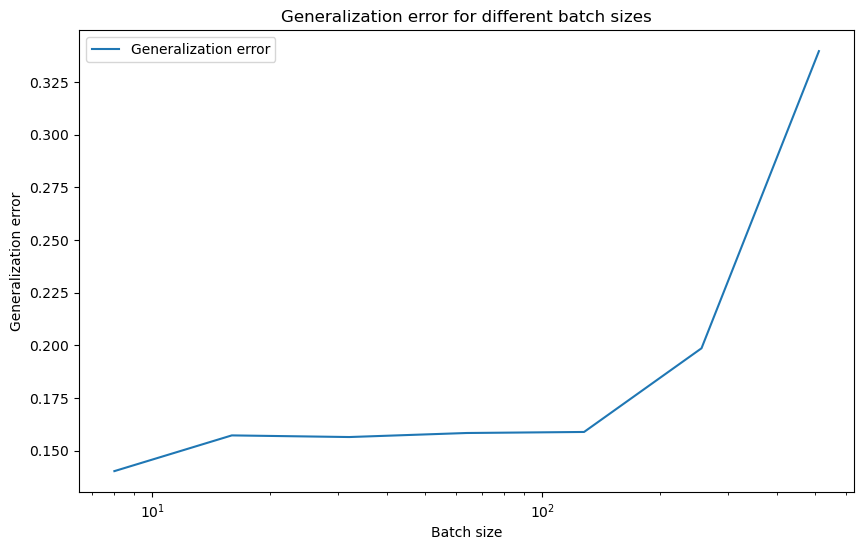

In [119]:
# Plot the generalization error for different batch sizes
plt.figure(figsize=(10, 6))
generalization_error = [abs(store_batch[batch_size][0][-1]- store_batch[batch_size][1][-1]) for batch_size in batch_sizes]
plt.plot(batch_sizes, generalization_error, label="Generalization error")
plt.xscale("log")
plt.xlabel("Batch size")
plt.ylabel("Generalization error")
plt.legend()
plt.title("Generalization error for different batch sizes")
plt.show()

> Finally, this plot shows us that by retaining the final epoch for each neural network, we notice that the neural network with the smallest batch size is the one that has the lowest generalization error, as expected. 

From what we have learned in lectures, we know the batch size is an important hyperparameter that can affect the performance of the model. The batch size determines how many training samples are processed at once before the model updates its parameters based on the calculated gradient. We notice that we obtain different behaviours depending on the batch size that we use.

For example, for small batch sizes, the training process is more stochastic, meaning that the model's parameters are updated more frequently based on smaller samples. This can lead to faster convergence, especially in the early stages of training. However, training with small batch sizes can be computationally expensive, as the model has to update its parameters more frequently, which can lead to slower training times. On the other hand, training with large batch sizes can be computationally efficient, as the model has to update its parameters less frequently. However, training with large batch sizes can lead to slower convergence, especially in the early stages of training.

Furthermore, according to the exercise guidelines, we should expect that "When we use a smaller batch size we increase the amount of noise that is used in the training process (because in each iteration we’re using a different dataset over which we compute the loss). This should then result in a smaller generalisation error." We are able to clearly observe this behaviour in our case and for this choice of parameters: the generalization error is clearly increasing as the batch size increases.

As we increase the batch size, the test loss increases as well. This is due to the fact that the batch size is the number of samples that are used to compute the gradient. Therefore, the larger the batch size, the more samples are used to compute the gradient and the more the gradient is smoothed. This is why the test loss is increasing as the batch size increases.



#### Task 9: Analyse the train and test errors as a function of width

According to the exercise guidance, we will now analyse the train and test errors as a function of width. We will do so by varying the number of neurons per hidden layer from 4 to 1024. We will also use a depth of 1, a learning rate of 0.001 and a batch size of 32. We train the different neural networks for 50 epochs using the Adam optimizer. Our goal is to find a plot similar to the one obtained in the exercise guidance for the MNIST dataset. We have tried multiple parameters setting and we have decided to use these parameters because they are the ones that allow us to achieve this goal.

In [12]:
# Define the hyperparameters
widths = [4, 8, 16, 32, 64, 128, 256, 512, 1024] # Varying hyperparameter
depth = 1 # Fixed hyperparameter according to exercise guidelines
lr = 0.001
epochs = 50
batch_size = 32
dim = 784
nclass = 10

# Store the results
store_widths = {}

# Run the main function for different widths
for width in widths:
    print(f"Width: {width}")
    train_loss, test_loss, train_error, test_error = main(batch_size, dim, nclass, width, depth, lr, epochs, train_set, test_set, Adam=True)
    store_widths[width] = [train_loss, test_loss, train_error, test_error]

Width: 4
Epoch: 001 | Train Loss: 1.144 | Test Loss: 0.906 | Train Error: 0.3987 | Test Error: 0.3092
Epoch: 002 | Train Loss: 0.8673 | Test Loss: 0.8367 | Train Error: 0.2821 | Test Error: 0.2709
Epoch: 003 | Train Loss: 0.817 | Test Loss: 0.8012 | Train Error: 0.2584 | Test Error: 0.2513
Epoch: 004 | Train Loss: 0.7854 | Test Loss: 0.7761 | Train Error: 0.2423 | Test Error: 0.2369
Epoch: 005 | Train Loss: 0.7618 | Test Loss: 0.7627 | Train Error: 0.2324 | Test Error: 0.2295
Epoch: 006 | Train Loss: 0.7457 | Test Loss: 0.7428 | Train Error: 0.226 | Test Error: 0.2222
Epoch: 007 | Train Loss: 0.7333 | Test Loss: 0.7318 | Train Error: 0.2213 | Test Error: 0.2198
Epoch: 008 | Train Loss: 0.7252 | Test Loss: 0.7268 | Train Error: 0.217 | Test Error: 0.2139
Epoch: 009 | Train Loss: 0.7185 | Test Loss: 0.7196 | Train Error: 0.2149 | Test Error: 0.2121
Epoch: 010 | Train Loss: 0.7131 | Test Loss: 0.7137 | Train Error: 0.213 | Test Error: 0.2127
Epoch: 011 | Train Loss: 0.7093 | Test Loss: 0.

In [89]:
# Construct pandas table of different train loss and test loss for different widths
df = pd.DataFrame(columns=["Width", "Train loss", "Test loss"])
for width in widths:
    df = pd.concat([df, pd.DataFrame([[width, store_widths[width][0][-1], store_widths[width][1][-1]]], columns=["Width", "Train loss", "Test loss"])])
df.reset_index(drop=True, inplace=True)
df

,Width,Train loss,Test loss
0,4,0.672056,0.691918
1,8,0.213136,0.268332
2,16,0.104483,0.203574
3,32,0.009754,0.201926
4,64,0.001367,0.194159
5,128,0.002753,0.177022
6,256,0.005230,0.203784
7,512,0.003303,0.164949
8,1024,0.005209,0.200425


Table of results in Markdown format for Task 9:

| Width | Train loss | Test loss |
| --- | --- | --- |
| 4 | 0.672056 | 0.691918 |
| 8 | 0.213136 | 0.268332 |
| 16 | 0.104483 | 0.203574 |
| 32 | 0.009754 | 0.201926 |
| 64 | 0.001367 | 0.194159 |
| 128 | 0.002753 | 0.177022 |
| 256 | 0.005230 | 0.203784 |
| 512 | 0.003303 | 0.164949 |
| 1024 | 0.005209 | 0.200425 |

> Note that it is normal that for small widths, our model has not quite converged yet. This is expected and is due to the fact that our neural network would then be underparametrized and would not be able to learn the data fully. This issue was also discussed on an [EdStem forum page](https://edstem.org/us/courses/32063/discussion/2686884).

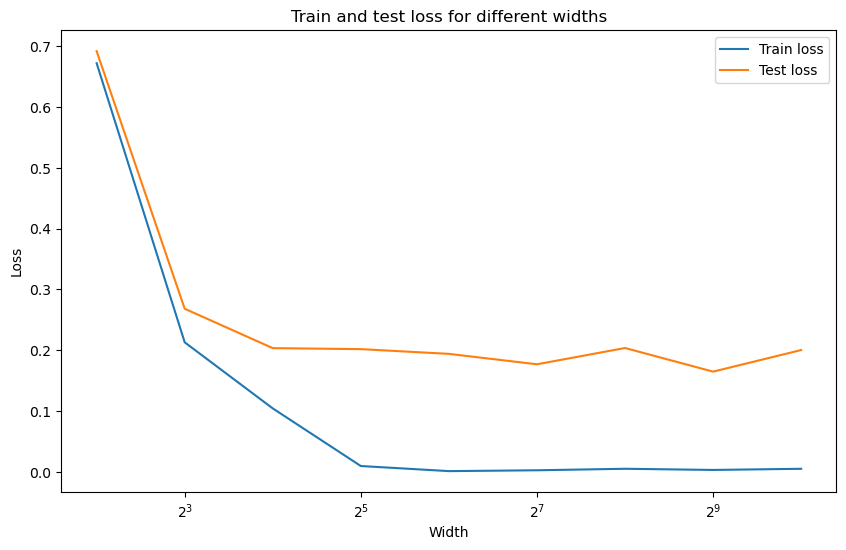

In [78]:
# Plot the train loss and the test loss for different widths (log scale x-axis)
plt.figure(figsize=(10, 6))
plt.plot(widths, [store_widths[width][0][-1] for width in widths], label="Train loss")
plt.plot(widths, [store_widths[width][1][-1] for width in widths], label="Test loss")
plt.xscale("log", base=2)
# Set the window axis limits (as in Figure 1)
plt.xlabel("Width")
plt.ylabel("Loss")
plt.legend()
plt.title("Train and test loss for different widths")
plt.show()


> By plotting the train and test losses, we obtain a graph where both the train and test losses are decreasing as the width increases. The train loss even gets very close to 0.

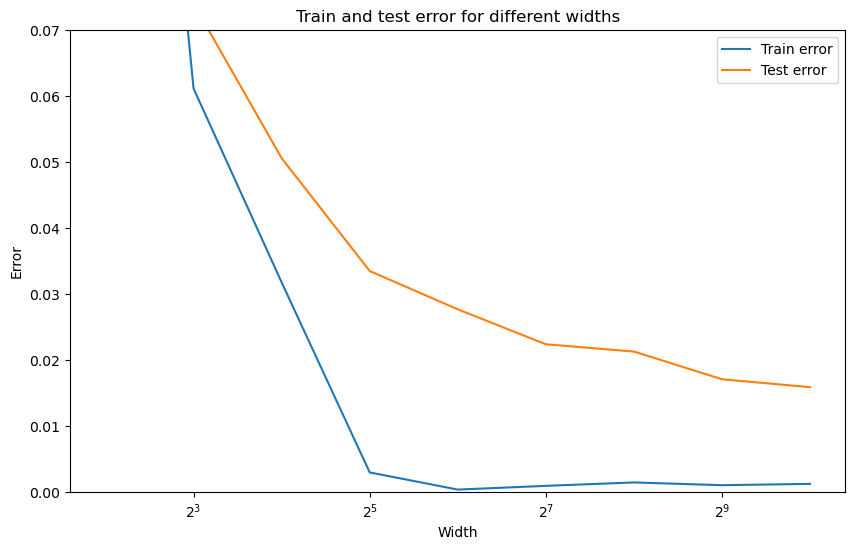

In [69]:
# Plot the train error and the test error for different widths (log scale x-axis)
plt.figure(figsize=(10, 6))
plt.plot(widths, [store_widths[width][2][-1] for width in widths], label="Train error")
plt.plot(widths, [store_widths[width][3][-1] for width in widths], label="Test error")
plt.xscale("log", base=2)
# Set the window axis limits (as in Figure 1)
plt.ylim(0, 0.07)
plt.xlabel("Width")
plt.ylabel("Error")
plt.legend()
plt.title("Train and test error for different widths")
plt.show()


> By plotting the train and test errors, we notice that we obtain a very similar graph to the one we were expecting in the assignment (using the same window size). Indeed, we can see that the train loss decreases as the width increases. This is because the more neurons we have in our neural network, the more complex it is and the more it is able to fit the training set. Similarly, as indicated in the guidance, the test error also decrease as the width increases.

After training the different neural networks, we can plot the train and test errors as a function of width. We can see that the train and test errors decrease as the width increases. Indeed, as indicated in the exercise guidelines, these results were expected: "Recent work  has shown that the test error continues to decrease (or at least not increase) even if we make the number of parameters very large. If we were to use the standard generalisation bounds, we would conclude that at some point we overfit on the data and the test error would start to increase." This is exactly what we can observe in our plot. The test error continues to decrease as the widths increases. In fact, our plot of errors looks very similar to the one obtained in the assignment guidance (which is a good sign): 

 ![](https://github.com/yanismiraoui/MFML-CW1-Ressources/blob/main/plot_MNIST.png?raw=true "MNIST plot to reproduce")

 Moreover, as indicated in the lectures, the width "makes things more convex" and therefore allows the neural network to fit the data better. Thus, it is normal and expected that the train and test errors decrease as the width increases.
It seems like we have successfully found a configuration parameters for which the test error and test loss decrease as there are more parameters in the network.

On the other hand, we could argue that an acceptable width for our neural network to fit the data well is around 64 neurons per hidden layer. Indeed, there is an important drop in the test error and test loss when the width is around 64 neurons per hidden layer. Moreover, there is a risk of overfitting the data when the width is too large as it could be over-parametrized.

## Part III: Extension to CIFAR10

Finally, in this Part III, we will extend our analysis to the CIFAR10 dataset. We would like to train a neural network on the CIFAR10 dataset and compare the performance of the network with the one we have trained on the MNIST dataset. Our goals is also to achieve to obtain a test accuracy higher than 0.55 (i.e. a test error lower than 0.45) using only fully connected layers.
> Please note that while we achieve to outperform the test accuracy, we may actually be overfitting to the particular test data we choose. However, we are told in this task to not "care about this issue".

#### Task 10: Test the performance on CIFAR10

In [128]:
# Import and load the CIFAR10 datasets 
train_set = torchvision.datasets.CIFAR10(root="./", download=True, train=True, transform=transforms.Compose([transforms.ToTensor()]),)
test_set = torchvision.datasets.CIFAR10(root="./", download=True, train=False, transform=transforms.Compose([transforms.ToTensor()]),)

Files already downloaded and verified
Files already downloaded and verified


After using a grid search over all the hyperparameters, we have found that the best hyperparameters for our neural network are the following:
- Number of hidden layers: 2
- Number of neurons per hidden layer: 1024
- Learning rate: 0.01
- Batch size: 64

Therefore, we train our neural network using these hyperparameters and we obtain the following results:

In [129]:
# Define the hyperparameters
depth = 2
width = 1024
lr = 0.01
epochs = 150
batch_size = 64
dim = 3072
nclass = 10

# Run the main function in order to train the model
train_loss, test_loss, train_error, test_error = main(batch_size, dim, nclass, width, depth, lr, epochs, train_set, test_set, Adam=False, momentum=0.9)
print("=========================================")
print("Training finished! Final results:")
print(f"Train Loss: {train_loss[-1]:.04} | Test Loss: {test_loss[-1]:.04} | Train Error: {train_error[-1]:.04} | Test Error: {test_error[-1]:.04}")

Epoch: 001 | Train Loss: 1.856 | Test Loss: 1.739 | Train Error: 0.672 | Test Error: 0.6346
Epoch: 002 | Train Loss: 1.657 | Test Loss: 1.605 | Train Error: 0.5935 | Test Error: 0.5789
Epoch: 003 | Train Loss: 1.567 | Test Loss: 1.529 | Train Error: 0.5589 | Test Error: 0.5438
Epoch: 004 | Train Loss: 1.506 | Test Loss: 1.555 | Train Error: 0.5407 | Test Error: 0.5604
Epoch: 005 | Train Loss: 1.455 | Test Loss: 1.478 | Train Error: 0.5197 | Test Error: 0.5269
Epoch: 006 | Train Loss: 1.416 | Test Loss: 1.465 | Train Error: 0.5083 | Test Error: 0.5227
Epoch: 007 | Train Loss: 1.375 | Test Loss: 1.41 | Train Error: 0.4915 | Test Error: 0.497
Epoch: 008 | Train Loss: 1.339 | Test Loss: 1.446 | Train Error: 0.4792 | Test Error: 0.5167
Epoch: 009 | Train Loss: 1.308 | Test Loss: 1.37 | Train Error: 0.468 | Test Error: 0.489
Epoch: 010 | Train Loss: 1.269 | Test Loss: 1.352 | Train Error: 0.4536 | Test Error: 0.4839
Epoch: 011 | Train Loss: 1.239 | Test Loss: 1.442 | Train Error: 0.4417 | Te

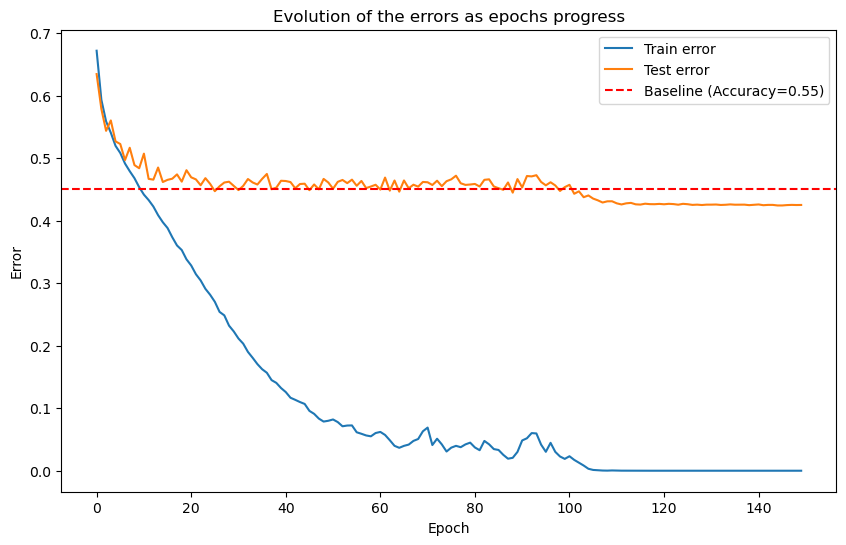

In [130]:
# Plot the evolution of the errors as epochs progress
plt.figure(figsize=(10, 6))
plt.plot(train_error, label="Train error")
plt.plot(test_error, label="Test error")
# Add a horizontal line at the threshold set to outperform the baseline
plt.axhline(y=0.45, color="r", linestyle="--", label="Baseline (Accuracy=0.55)")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("Evolution of the errors as epochs progress")
plt.legend()
plt.show()

In [131]:
print("=========================================")
print("Bonus question:")
print("=========================================")
print("Did we achieve to outperform the accuracy of 0.55? Last test accuracy obtained:", 1-test_error[-1])
if 1-test_error[-1] > 0.55:
    print("Yes, we did, hoorah!")
else:
    print("No, we did not...")

Bonus question:
Did we achieve to outperform the accuracy of 0.55? Last test accuracy obtained: 0.5748
Yes, we did, hoorah!


In [132]:
# Same parameters for the training of MNIST for comparison
train_set = torchvision.datasets.MNIST(root="./", download=True, train=True, transform=transforms.Compose([transforms.ToTensor()]),)
test_set = torchvision.datasets.MNIST(root="./", download=True, train=False, transform=transforms.Compose([transforms.ToTensor()]),)

# Define the hyperparameters as before
depth = 2
width = 1024
lr = 0.01
epochs = 150
batch_size = 64
dim = 784
nclass = 10

# Run the main function in order to train the model
train_loss, test_loss, train_error, test_error = main(batch_size, dim, nclass, width, depth, lr, epochs, train_set, test_set, Adam=False, momentum=0.9)
print("=========================================")
print("Training finished! Final results:")
print(f"Train Loss: {train_loss[-1]:.04} | Test Loss: {test_loss[-1]:.04} | Train Error: {train_error[-1]:.04} | Test Error: {test_error[-1]:.04}")

Epoch: 001 | Train Loss: 0.4606 | Test Loss: 0.2182 | Train Error: 0.1255 | Test Error: 0.0633
Epoch: 002 | Train Loss: 0.1686 | Test Loss: 0.1293 | Train Error: 0.04963 | Test Error: 0.04
Epoch: 003 | Train Loss: 0.1099 | Test Loss: 0.09573 | Train Error: 0.03268 | Test Error: 0.0278
Epoch: 004 | Train Loss: 0.07997 | Test Loss: 0.08575 | Train Error: 0.02345 | Test Error: 0.026
Epoch: 005 | Train Loss: 0.06183 | Test Loss: 0.07379 | Train Error: 0.01807 | Test Error: 0.0245
Epoch: 006 | Train Loss: 0.04766 | Test Loss: 0.07081 | Train Error: 0.01393 | Test Error: 0.0221
Epoch: 007 | Train Loss: 0.03792 | Test Loss: 0.06404 | Train Error: 0.01132 | Test Error: 0.0209
Epoch: 008 | Train Loss: 0.03018 | Test Loss: 0.0593 | Train Error: 0.008633 | Test Error: 0.0201
Epoch: 009 | Train Loss: 0.02372 | Test Loss: 0.0606 | Train Error: 0.00615 | Test Error: 0.0199
Epoch: 010 | Train Loss: 0.01856 | Test Loss: 0.06571 | Train Error: 0.004367 | Test Error: 0.0213
Epoch: 011 | Train Loss: 0.01

We achieved to obtain a test accuracy higher than 0.55 (i.e. a test error lower than 0.45)! At first sight, this would seem to be a good result. However, we may actually be overfitting to the particular test data we choose. Moreover, when performing our grid search, we could notice that making our layers wider was allowing us to obtain better results (as it makes our problem more convex).

On the other hand, we notice that the CIFAR10 dataset is much more complex than the MNIST dataset. Indeed, the MNIST dataset contains images of handwritten digits whereas the CIFAR10 dataset contains images of 10 different classes of objects. Moreover, by analysing the test error that we obtain on both datasets, we notice a quite important difference. Indeed, we obtain a test error of 0.42 on the CIFAR10 dataset, whereas we can easily obtain a test error below 0.02 on the MNIST dataset. Therefore, we can expect that the CIFAR10 dataset is much more complex than the MNIST dataset. This would make sense as the nature of the images is very different for both datasets. Detecting handwritten digits is much easier than detecting objects in images.

We could make a similar parallel with the famous dataset Fashion-MNIST. It is a dataset of Zalando's article images, which is very similar to the MNIST dataset. However, the Fashion-MNIST dataset is much more complex than the MNIST dataset. Indeed, the Fashion-MNIST dataset contains images of 10 different classes of clothing. The Fashion-MNIST is famous to be a good dataset to test the performance of a neural network on a more complex dataset than the MNIST dataset. Similarly as for the CIFAR10 dataset, it is therefore much more difficult to obtain a good performance on the Fashion-MNIST dataset than on the MNIST dataset. We observe the same behaviour in our case for the MNIST and the CIFAR10 datasets.